<a href="https://colab.research.google.com/github/CYL24/macs/blob/main/visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import time
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import cv2
import matplotlib.pyplot as plt
from torch import nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
import random
import numpy as np
import torch
import re
import plotly.graph_objects as go
from wordcloud import WordCloud
import spacy
from collections import defaultdict
from textblob import TextBlob
from collections import defaultdict
from keras.preprocessing.image import load_img
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
from PIL import Image
import os
import string

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def readText(path):
    with open(path) as f:
        captions = f.read()
    return captions


# Function to load images from a local path
def load_image_from_path(img_path, filename):
    return Image.open(os.path.join(img_path, filename))

In [ ]:
captions = readText('/content/drive/My Drive/Colab Notebooks/final_project/Flickr8k_text/Flickr8k.token.txt')
img_path = '/content/drive/My Drive/Colab Notebooks/final_project/Flickr8k_Dataset/'

In [ ]:
captions = captions.split('\n')[:-1]
captions1 = [caption.split('\t')[1] for caption in captions]  # Extracting the actual caption text
print(captions1[:10])

['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .', 'A black dog and a spotted dog are fighting', 'A black dog and a tri-colored dog playing with each other on the road .', 'A black dog and a white dog with brown spots are staring at each other in the street .', 'Two dogs of different breeds looking at each other on the road .', 'Two dogs on pavement moving toward each other .']


In [ ]:
# Function to display images with all captions
def visualization(data, num_of_images, img_path):
    # We use dictionaries to access captions of each image by its ID
    captions_dictionary = {}
    for item in data[:num_of_images * 5]:  # Adjusted to select the first 'num_of_images' images with all their captions
        image_id, caption = item.split('\t')
        image_id = image_id.split('#')[0]  # Remove the part after '#'
        if image_id not in captions_dictionary:
            captions_dictionary[image_id] = []
        captions_dictionary[image_id].append(caption)

    fig = plt.figure(figsize=(num_of_images * 8, 10))
    gs = plt.GridSpec(2, num_of_images, height_ratios=[10, 1])

    colors = ['red', 'blue', 'green', 'purple', 'orange']

    for i, (filename, captions) in enumerate(captions_dictionary.items()):
        if i >= num_of_images:
            break

        # Load image from local path
        image_load = load_image_from_path(img_path, filename)

        # Display image
        ax = fig.add_subplot(gs[0, i])
        ax.imshow(image_load)
        ax.axis('off')

        # Display captions
        ax = fig.add_subplot(gs[1, i])
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0, 1)
        ax.set_ylim(0, len(captions))
        for j, caption in enumerate(captions):
            color = colors[j % len(colors)]
            ax.text(0, len(captions) - 1 - j, caption, fontsize=14, color=color, wrap=True, va='top')

    plt.tight_layout()
    plt.show()

visualization(captions, 5, img_path)

In [ ]:
# List of words to embed
male_words = ['man', 'boy', 'king', 'prince', 'father', 'son', 'brother', 'husband', 'uncle', 'nephew',
              'grandfather', 'cousin (male)', 'mr.', 'sir', 'gentleman', 'duke', 'lord', 'male', 'actor']
female_words = ['woman', 'girl', 'queen', 'princess', 'mother', 'daughter', 'sister', 'wife', 'aunt', 'niece',
                'grandmother', 'cousin (female)', 'mrs.', 'miss', 'madam', 'lady', 'duchess', 'lady', 'female', 'actress']

In [ ]:
from collections import Counter

male_counter = Counter()
female_counter = Counter()

for caption in captions1:
    words = caption.lower().split()
    for word in words:
        if word in male_words:
            male_counter[word] += 1
        elif word in female_words:
            female_counter[word] += 1

male_df = pd.DataFrame(male_counter.items(), columns=['Word','Male Count'])
female_df = pd.DataFrame(female_counter.items(), columns=['Word', 'Female Count'])
display(male_df)
display(female_df)

Word  Male Count
0         man        7266
1         boy        3581
2        male         113
3      father          24
4   gentleman          15
5     brother          12
6         son          10
7        duke           2
8         mr.           3
9        king           1
10      actor           1

Word  Female Count
0          girl          3328
1         woman          3403
2          lady           223
3        mother            43
4      daughter            16
5        female           103
6      princess             2
7        sister             9
8   grandmother             1
9          wife             3
10        queen             2

In [ ]:
# Combine counters for visualization
all_genders = list(male_counter.keys()) + list(female_counter.keys())
all_counts = list(male_counter.values()) + list(female_counter.values())
genders = ['male'] * len(male_counter) + ['female'] * len(female_counter)

total_count = sum(all_counts)
percentages = [count / total_count * 100 for count in all_counts]

# Sort the data by count in descending order
sorted_indices = np.argsort(all_counts)[::-1]
all_genders = np.array(all_genders)[sorted_indices]
all_counts = np.array(all_counts)[sorted_indices]
genders = np.array(genders)[sorted_indices]

# Top 8 words and others
top_n = 8
top_genders = all_genders[:top_n].tolist()
top_counts = all_counts[:top_n].tolist()
top_genders.append('Others')
top_counts.append(sum(all_counts[top_n:]))

# pie chart
colors = ['#1f77b4' if gender == 'male' else '#ff7f0e' for gender in genders[:top_n]]
colors.append('#2ca02c')  # Color for 'Others'

fig = go.Figure(data=[go.Pie(labels=top_genders, values=top_counts, hole=.6, marker=dict(colors=colors), textinfo='label+percent')])
fig.update_layout(
    title_text='Gendered Word Counts in Captions (Top 8 and Others)',
    title_font=dict(size=25, family='Balto'),
    title_x=0.5,
    width=600,
    height=600
)
fig.show()

In [ ]:
profession_keywords = [
    'accountant', 'animator', 'architect', 'assistant', 'author', 'caretaker', 'chef', 'clerk',
    'cook', 'civil servant', 'career counselor', 'economist', 'editor', 'electrician', 'engineer',
    'executive', 'farmer', 'flight attendant', 'geologist', 'hairdresser', 'jeweler', 'journalist',
    'judge', 'juggler', 'lawyer', 'lecturer', 'lexicographer', 'receptionist', 'sailor', 'salesperson',
    'scientist', 'secretary', 'singer', 'soldier', 'solicitor', 'surgeon', 'tailor', 'teacher',
    'telephonist', 'baker', 'biologist', 'builder', 'butcher', 'decorator', 'dentist', 'designer',
    'diplomat', 'director', 'doctor', 'magician', 'makeup artist', 'manager', 'miner', 'musician',
    'nurse', 'optician', 'prison officer', 'painter', 'personal assistant', 'photographer', 'pilot',
    'plumber', 'police officer', 'politician', 'porter', 'printer', 'puppeteer', 'web designer',
    'company director', 'library assistant', 'sign language interpreter', 'shop assistant',
    'computer programmer', 'comic book writer', 'garbage collector', 'film director', 'head teacher'
]

In [ ]:
# Count professions by gender

male_profession_counter = Counter()
female_profession_counter = Counter()

for caption in captions:
    words = caption.lower().split()
    for word in words:
        if word in profession_keywords:
            if any(male_word in words for male_word in male_words):
                male_profession_counter[word] += 1
            elif any(female_word in words for female_word in female_words):
                female_profession_counter[word] += 1

male_df = pd.DataFrame(male_profession_counter.items(), columns=['Profession', 'Male Count'])
female_df = pd.DataFrame(female_profession_counter.items(), columns=['Profession', 'Female Count'])

merged_df = pd.merge(male_df, female_df, on='Profession', how='outer').fillna(0)
merged_df = merged_df.astype({'Male Count': 'int', 'Female Count': 'int'})

#sorting
merged_df['Total Count'] = merged_df['Male Count'] + merged_df['Female Count']
top_10_df = merged_df.sort_values(by='Total Count', ascending=False).head(10)
display(top_10_df)

Profession  Male Count  Female Count  Total Count
1  photographer           2             2            4
2        sailor           4             0            4
3         judge           2             0            2
4        singer           1             1            2
0      magician           1             0            1
5         pilot           1             0            1
6      musician           1             0            1
7          chef           1             0            1
8        farmer           0             1            1

In [ ]:
# Example activity keywords
activity_keywords = [
    'baking', 'begging', 'biking', 'calling', 'cleaning', 'climbing', 'cooking',
    'coughing', 'crying', 'drinking', 'driving', 'eating', 'exercising', 'falling',
    'fishing', 'hitting', 'hugging', 'jogging', 'jumping', 'kicking', 'kneeling',
    'laughing', 'lifting', 'painting', 'pitching', 'waving', 'picking', 'praying',
    'reading', 'riding', 'rowing', 'running', 'serving', 'sewing', 'shopping',
    'shouting', 'sitting', 'skating', 'sleeping', 'smiling', 'speaking', 'spying',
    'standing', 'staring', 'stretching', 'studying', 'sweeping', 'talking',
    'throwing', 'walking', 'washing', 'working'
]

In [ ]:
# Count activities by gender
male_activity_counter = Counter()
female_activity_counter = Counter()

for caption in captions:
    words = caption.lower().split()
    for word in words:
        if word in activity_keywords:
            if any(male_word in words for male_word in male_words):
                male_activity_counter[word] += 1
            elif any(female_word in words for female_word in female_words):
                female_activity_counter[word] += 1

male_activity_df = pd.DataFrame(male_activity_counter.items(), columns=['Activity', 'Male Count'])
female_activity_df = pd.DataFrame(female_activity_counter.items(), columns=['Activity', 'Female Count'])
merged_activity_df = pd.merge(male_activity_df, female_activity_df, on='Activity', how='outer').fillna(0)
merged_activity_df = merged_activity_df.astype({'Male Count': 'int', 'Female Count': 'int'})

# Sort to get top 10 activities
top_10_activities_male = merged_activity_df.sort_values(by=['Male Count', 'Female Count'], ascending=False).head(10)
top_10_activities_female = merged_activity_df.sort_values(by=['Female Count', 'Male Count'], ascending=False).head(10)

display(top_10_activities_female)
display(top_10_activities_male)

Activity  Male Count  Female Count
1    sitting         454           282
2   standing         603           265
4    walking         257           196
11   jumping         360           161
5    smiling         154           137
14   running         183           120
13    riding         312           114
6   climbing         225            83
10    eating          46            41
21   talking          52            38

Activity  Male Count  Female Count
2   standing         603           265
1    sitting         454           282
11   jumping         360           161
13    riding         312           114
4    walking         257           196
6   climbing         225            83
14   running         183           120
5    smiling         154           137
22   fishing          64             6
21   talking          52            38

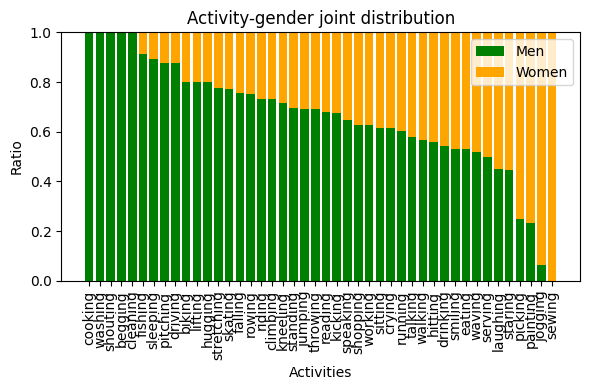

In [ ]:
# Normalize counts for joint distribution
merged_activity_df['Total Count'] = merged_activity_df['Male Count'] + merged_activity_df['Female Count']
merged_activity_df['Male Ratio'] = merged_activity_df['Male Count'] / merged_activity_df['Total Count']
merged_activity_df['Female Ratio'] = merged_activity_df['Female Count'] / merged_activity_df['Total Count']

# Sort by Male Ratio for better visualization
merged_activity_df = merged_activity_df.sort_values(by='Male Ratio', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(merged_activity_df['Activity'], merged_activity_df['Male Ratio'], label='Men', color='green')
ax.bar(merged_activity_df['Activity'], merged_activity_df['Female Ratio'], bottom=merged_activity_df['Male Ratio'], label='Women', color='orange')
ax.set_ylabel('Ratio')
ax.set_xlabel('Activities')
ax.set_title('Activity-gender joint distribution')
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

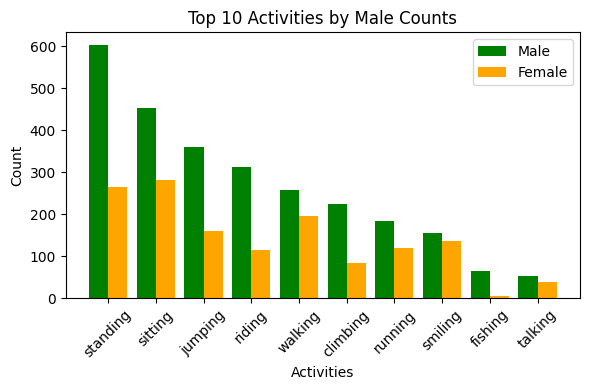

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
index = range(len(top_10_activities_male))

bar1 = ax.bar(index, top_10_activities_male['Male Count'], bar_width, label='Male', color='green')
bar2 = ax.bar([i + bar_width for i in index], top_10_activities_male['Female Count'], bar_width, label='Female', color='orange')

ax.set_xlabel('Activities')
ax.set_ylabel('Count')
ax.set_title('Top 10 Activities by Male Counts')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_10_activities_male['Activity'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
index = range(len(top_10_activities_female))

bar1 = ax.bar(index, top_10_activities_female['Female Count'], bar_width, label='Female', color='orange')
bar2 = ax.bar([i + bar_width for i in index], top_10_activities_female['Male Count'], bar_width, label='Male', color='green')

ax.set_xlabel('Activities')
ax.set_ylabel('Count')
ax.set_title('Top 10 Activities by Female Counts')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_10_activities_female['Activity'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Example object keywords
object_keywords = [
    'scotch', 'briefcase', 'jersey', 'whiskey', 'suit', 'beer', 'tie', 'gun', 'cigar', 'golf',
    'helmet', 'junk', 'punch', 'bike', 'tool', 'meat', 'barbecue', 'steak', 'cat', 'scarf',
    'wine', 'basketball', 'hamburger', 'bacon', 'bat', 'pie', 'fruit', 'jewellery', 'necklace',
    'makeup', 'purse', 'salad', 'yarn', 'aviator', 'piercing', 'healthy', 'apron', 'candle', 'perfume'
]

In [ ]:
# Count objects by gender

male_object_counter = Counter()
female_object_counter = Counter()

for caption in captions:
    words = caption.lower().split()
    for word in words:
        if word in object_keywords:
            if any(male_word in words for male_word in male_words):
                male_object_counter[word] += 1
            elif any(female_word in words for female_word in female_words):
                female_object_counter[word] += 1

male_object_df = pd.DataFrame(male_object_counter.items(), columns=['Object', 'Male Count'])
female_object_df = pd.DataFrame(female_object_counter.items(), columns=['Object', 'Female Count'])
merged_object_df = pd.merge(male_object_df, female_object_df, on='Object', how='outer').fillna(0)
merged_object_df = merged_object_df.astype({'Male Count': 'int', 'Female Count': 'int'})

# Sort and get the top 10 object
top_10_objects_female = merged_object_df.sort_values(by=['Female Count', 'Male Count'], ascending=False).head(10)
top_10_objects_male = merged_object_df.sort_values(by=['Male Count', 'Female Count'], ascending=False).head(10)

display(top_10_objects_male)
display(top_10_objects_female)

Object  Male Count  Female Count
2         bike         400            81
3       helmet         164            51
5         suit         127            80
11  basketball         111            13
8          bat          52             9
1       jersey          47             4
7          tie          31             6
0         beer          25             4
12       scarf          22            53
4          gun          20             5

Object  Male Count  Female Count
2         bike         400            81
5         suit         127            80
12       scarf          22            53
3       helmet         164            51
6        purse           2            30
9     necklace          14            15
18      makeup           6            14
11  basketball         111            13
8          bat          52             9
17         cat           5             9

In [ ]:
# Normalize counts for joint distribution
merged_object_df['Total Count'] = merged_object_df['Male Count'] + merged_object_df['Female Count']
merged_object_df['Male Ratio'] = merged_object_df['Male Count'] / merged_object_df['Total Count']
merged_object_df['Female Ratio'] = merged_object_df['Female Count'] / merged_object_df['Total Count']

merged_object_df = merged_object_df.sort_values(by='Male Ratio', ascending=False)

# Plot
fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(merged_object_df['Object'], merged_object_df['Male Ratio'], label='Men', color='green')
ax.bar(merged_object_df['Object'], merged_object_df['Female Ratio'], bottom=merged_object_df['Male Ratio'], label='Women', color='orange')
ax.set_ylabel('Ratio')
ax.set_xlabel('Object')
ax.set_title('Object-gender joint distribution')
ax.legend()

plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
index = range(len(top_10_objects_male))

bar1 = ax.bar(index, top_10_objects_male['Male Count'], bar_width, label='Male', color='green')
bar2 = ax.bar([i + bar_width for i in index], top_10_objects_male['Female Count'], bar_width, label='Female', color='orange')

ax.set_xlabel('Objects')
ax.set_ylabel('Count')
ax.set_title('Top 10 Objects by Male Counts')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_10_objects_male['Object'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Plotting
fig, ax = plt.subplots(figsize=(6, 4))
bar_width = 0.4
index = range(len(top_10_objects_female))

bar1 = ax.bar(index, top_10_objects_female['Female Count'], bar_width, label='Female', color='orange')
bar2 = ax.bar([i + bar_width for i in index], top_10_objects_female['Male Count'], bar_width, label='Male', color='green')

ax.set_xlabel('Objects')
ax.set_ylabel('Count')
ax.set_title('Top 10 Objects by Female Counts')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(top_10_objects_female['Object'])
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# context analysis
nlp = spacy.load("en_core_web_sm")
stopwords = nlp.Defaults.stop_words
stopwords.update(string.punctuation)


def extract_sentences_with_gendered_words(captions, gendered_words):
    sentences = []
    for caption in captions:
        for word in gendered_words:
            if re.search(r'\b' + re.escape(word) + r'\b', caption.lower()):
                sentences.append(caption)
                break
    return sentences

def remove_stopwords(text):
    doc = nlp(text)
    return " ".join([token.text for token in doc if token.text.lower() not in stopwords])

male_sentences = extract_sentences_with_gendered_words(captions, male_words)
female_sentences = extract_sentences_with_gendered_words(captions, female_words)

male_sentences = [remove_stopwords(sentence) for sentence in male_sentences]
female_sentences = [remove_stopwords(sentence) for sentence in female_sentences]

print("Male sentences:", male_sentences[:5])
print("Female sentences:", female_sentences[:5])

Male sentences: ['1003163366_44323f5815.jpg#0 \t man lays bench dog sits', '1003163366_44323f5815.jpg#1 \t man lays bench white dog tied', '1003163366_44323f5815.jpg#2 \t man sleeping bench outside white black dog sitting', '1003163366_44323f5815.jpg#3 \t shirtless man lies park bench dog', '1003163366_44323f5815.jpg#4 \t man laying bench holding leash dog sitting ground']
Female sentences: ['1000268201_693b08cb0e.jpg#1 \t girl going wooden building', '1000268201_693b08cb0e.jpg#2 \t little girl climbing wooden playhouse', '1000268201_693b08cb0e.jpg#3 \t little girl climbing stairs playhouse', '1000268201_693b08cb0e.jpg#4 \t little girl pink dress going wooden cabin', '1002674143_1b742ab4b8.jpg#0 \t little girl covered paint sits painted rainbow hands bowl']


In [ ]:
def analyze_context(sentences, gendered_words):
    context_data = []
    for sentence in sentences:
        doc = nlp(sentence)
        for token in doc:
            if token.text.lower() in gendered_words:
                left_context = doc[max(0, token.i - 5): token.i]
                right_context = doc[token.i + 1: min(len(doc), token.i + 6)]
                context_data.append({
                    "word": token.text,
                    "left_context": " ".join([t.text for t in left_context]),
                    "right_context": " ".join([t.text for t in right_context])
                })
    return context_data

male_contexts = analyze_context(male_sentences, male_words)
female_contexts = analyze_context(female_sentences, female_words)

In [ ]:
# Function to generate word cloud from context data
def generate_word_cloud(context_data, title):
    left_context_counter = Counter()
    right_context_counter = Counter()

    for context in context_data:
        left_context_counter.update(context['left_context'].split())
        right_context_counter.update(context['right_context'].split())

    left_context_wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(left_context_counter)
    right_context_wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(right_context_counter)

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    axs[0].imshow(left_context_wordcloud, interpolation='bilinear')
    axs[0].axis('off')
    axs[0].set_title(f'{title} - Left Context')

    axs[1].imshow(right_context_wordcloud, interpolation='bilinear')
    axs[1].axis('off')
    axs[1].set_title(f'{title} - Right Context')

    plt.show()

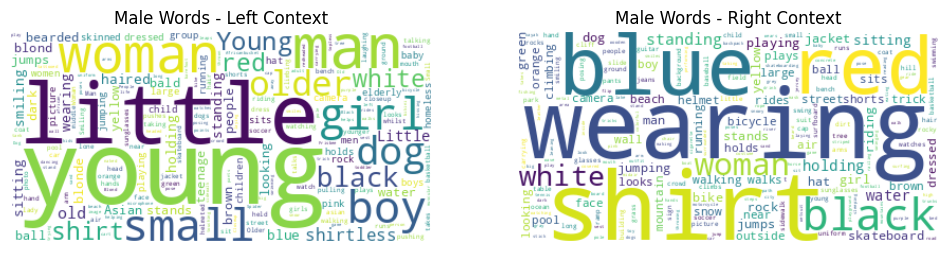

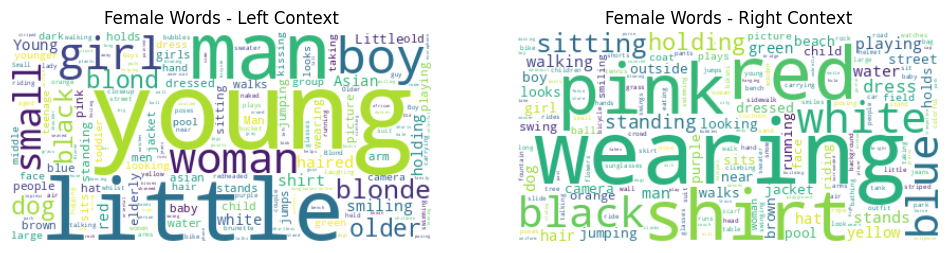

In [ ]:
# Generate word clouds for male and female contexts
generate_word_cloud(male_contexts, "Male Words")
generate_word_cloud(female_contexts, "Female Words")

In [ ]:
# sentiment analysis using TextBlob
def analyze_sentiment(sentences):
    sentiments = {"positive": 0, "negative": 0, "neutral": 0}
    for sentence in sentences:
        blob = TextBlob(sentence)
        sentiment = blob.sentiment.polarity
        if sentiment > 0:
            sentiments["positive"] += 1
        elif sentiment < 0:
            sentiments["negative"] += 1
        else:
            sentiments["neutral"] += 1
    return sentiments

male_sentiment = analyze_sentiment(male_sentences)
female_sentiment = analyze_sentiment(female_sentences)

print("Male sentiment:", male_sentiment)
print("Female sentiment:", female_sentiment)

Male sentiment: {'positive': 2002, 'negative': 2370, 'neutral': 6116}
Female sentiment: {'positive': 1338, 'negative': 1967, 'neutral': 3473}


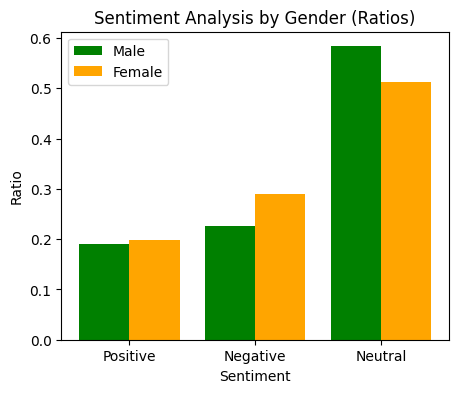

In [ ]:
# Calculate ratios
total_male_sentences = len(male_sentences)
total_female_sentences = len(female_sentences)
male_ratios = {key: value / total_male_sentences for key, value in male_sentiment.items()}
female_ratios = {key: value / total_female_sentences for key, value in female_sentiment.items()}

# Prepare data for visualization
labels = ["Positive", "Negative", "Neutral"]
male_ratios_list = [male_ratios["positive"], male_ratios["negative"], male_ratios["neutral"]]
female_ratios_list = [female_ratios["positive"], female_ratios["negative"], female_ratios["neutral"]]

x = range(len(labels))

# Plotting the data
fig, ax = plt.subplots(figsize=(5, 4))

ax.bar(x, male_ratios_list, width=0.4, label='Male', align='center', color='green')
ax.bar([i + 0.4 for i in x], female_ratios_list, width=0.4, label='Female', align='center', color='orange')

ax.set_xlabel('Sentiment')
ax.set_ylabel('Ratio')
ax.set_title('Sentiment Analysis by Gender (Ratios)')
ax.set_xticks([i + 0.2 for i in x])
ax.set_xticklabels(labels)
ax.legend()

plt.show()

In [ ]:
stopwords = nlp.Defaults.stop_words
stopwords.update(string.punctuation)

def co_occurrence_analysis(sentences, gendered_words, stopwords):
    co_occurrence = defaultdict(Counter)
    for sentence in sentences:
        words = sentence.lower().split()
        filtered_words = [word for word in words if word not in stopwords]
        for word in filtered_words:
            if word not in gendered_words:
                for gendered_word in gendered_words:
                    if gendered_word in words:
                        co_occurrence[gendered_word][word] += 1
    return co_occurrence

def extract_sentences_with_gendered_words(captions, gendered_words):
    sentences = []
    for caption in captions:
        for word in gendered_words:
            if re.search(r'\b' + re.escape(word) + r'\b', caption.lower()):
                sentences.append(caption)
                break
    return sentences

male_sentences_co = extract_sentences_with_gendered_words(captions, male_words)
female_sentences_co = extract_sentences_with_gendered_words(captions, female_words)

# Perform co-occurrence analysis
male_co_occurrence = co_occurrence_analysis(male_sentences_co, male_words, stopwords)
female_co_occurrence = co_occurrence_analysis(female_sentences_co, female_words, stopwords)

# Remove gendered words from co-occurrence results
def remove_opposite_gendered_words(co_occurrence, opposite_gendered_words):
    for gendered_word in co_occurrence.keys():
        for opposite_word in opposite_gendered_words:
            if opposite_word in co_occurrence[gendered_word]:
                del co_occurrence[gendered_word][opposite_word]
    return co_occurrence

male_co_occurrence = remove_opposite_gendered_words(male_co_occurrence, female_words)
female_co_occurrence = remove_opposite_gendered_words(female_co_occurrence, male_words)

print("Male co-occurrence:", dict(male_co_occurrence))
print("Female co-occurrence:", dict(female_co_occurrence))

Male co-occurrence: {'man': Counter({'wearing': 825, 'shirt': 679, 'black': 602, 'white': 540, 'red': 539, 'standing': 469, 'blue': 466, 'young': 390, 'dog': 389, 'sitting': 376, 'holding': 374, 'bike': 305, 'hat': 302, 'stands': 300, 'rock': 291, 'water': 287, 'jacket': 255, 'yellow': 241, 'street': 232, 'riding': 222, 'bicycle': 206, 'walking': 205, 'sits': 198, 'near': 198, 'green': 192, 'large': 191, 'playing': 190, 'camera': 182, 'looking': 176, 'climbing': 174, 'air': 174, 'jumping': 172, 'people': 167, 'holds': 160, 'orange': 159, 'brown': 158, 'wall': 155, 'looks': 150, 'bench': 148, 'dressed': 145, 'mountain': 143, 'skateboard': 143, 'sunglasses': 135, 'beach': 132, 'ball': 131, 'jumps': 131, 'outside': 130, 'child': 129, 'building': 129, 'walks': 128, 'trick': 128, 'helmet': 121, 'rides': 120, 'background': 118, 'sign': 118, 'shorts': 117, 'snow': 115, 'face': 110, 'suit': 109, 'crowd': 108, 'picture': 106, 'dirt': 105, 'glasses': 102, 'ocean': 101, 'cap': 100, 'hair': 100, '

In [ ]:
# Generate and display the word clouds
def generate_wordcloud(wordcloud_data, title):
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(wordcloud_data)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=20)
    plt.axis('off')
    plt.show()

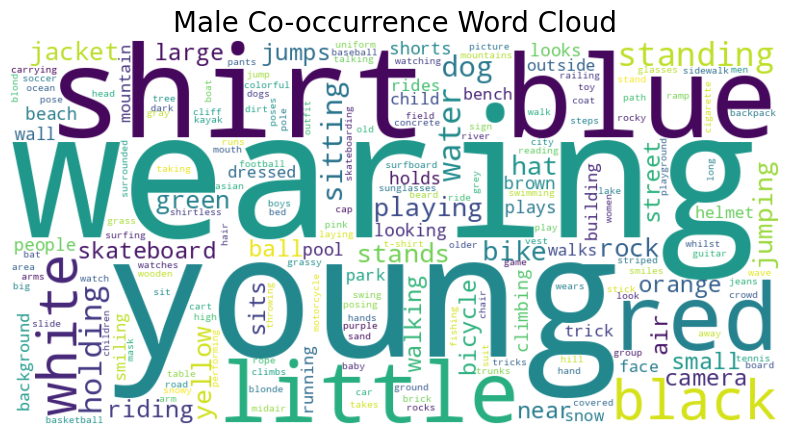

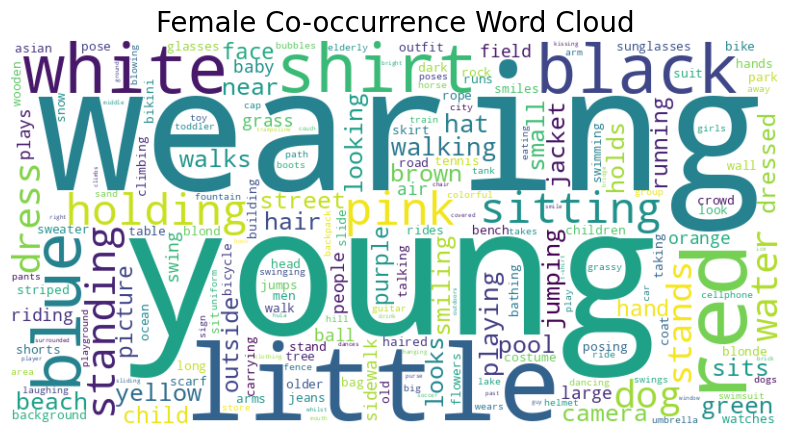

In [ ]:
# Convert co-occurrence counts to a format suitable for WordCloud
def get_wordcloud_data(co_occurrence_dict):
    wordcloud_data = Counter()
    for key, counter in co_occurrence_dict.items():
        wordcloud_data.update(counter)
    return wordcloud_data

male_wordcloud_data = get_wordcloud_data(male_co_occurrence)
female_wordcloud_data = get_wordcloud_data(female_co_occurrence)

generate_wordcloud(male_wordcloud_data, "Male Co-occurrence Word Cloud")
generate_wordcloud(female_wordcloud_data, "Female Co-occurrence Word Cloud")